#### Imports

In [1]:
import sys
import os
import os.path

import numpy as np
import skimage.io
import glob

import shutil
#from config import config_vars

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import skimage.morphology

import tensorflow as tf
import keras

import utils.metrics
import utils.model_builder
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
import seaborn as sb
import skimage.morphology
import skimage.segmentation

import utils.evaluation

#### Since last time:

> Tried cropping instead of resizing
>
> Visually evaluated the models predictions on a subset of the images
>
> Chose the most problematic 5 + with high resolution
>
> Manually annotated these 5 using cvat
> 
> Tried to augment using affine transformation (elastic) but had problems 
> 
> Converted into the correct format and trained the network on 3 of these 5 images (using rotation and illumination augmentation)
>
> Visually evaluated the models on all the images, and numerically evaluated on the 2 manually annotated images that the model had not been trained on
>

#### Cropped images:

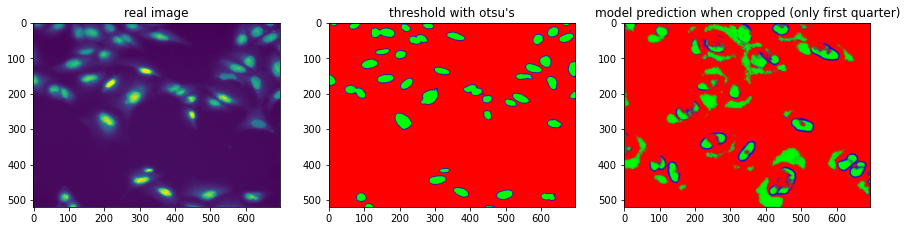

In [22]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/norm_images'))
filename.remove('.ipynb_checkpoints')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
thresh = skimage.io.imread('/home/jupyter/aitslab_images/boundary_labels/otsus/' + filename[0])
i2 = skimage.io.imread('/home/jupyter/experiments/aits_cropped/out/prob/' + filename[0])

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title("real image")
plt.imshow(img)
plt.subplot(132)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(133)
plt.title("model prediction when cropped (only first quarter)")
plt.imshow(i2)
plt.savefig("comp.png")

> Same problem as when we made the model predict on full size images (just a cropped version)

#### Augment manually augmented images using affine transformations (elastic)

> see images
>

#### Visual comparison of Otsus, first model, and second model 

Image nbr: 0


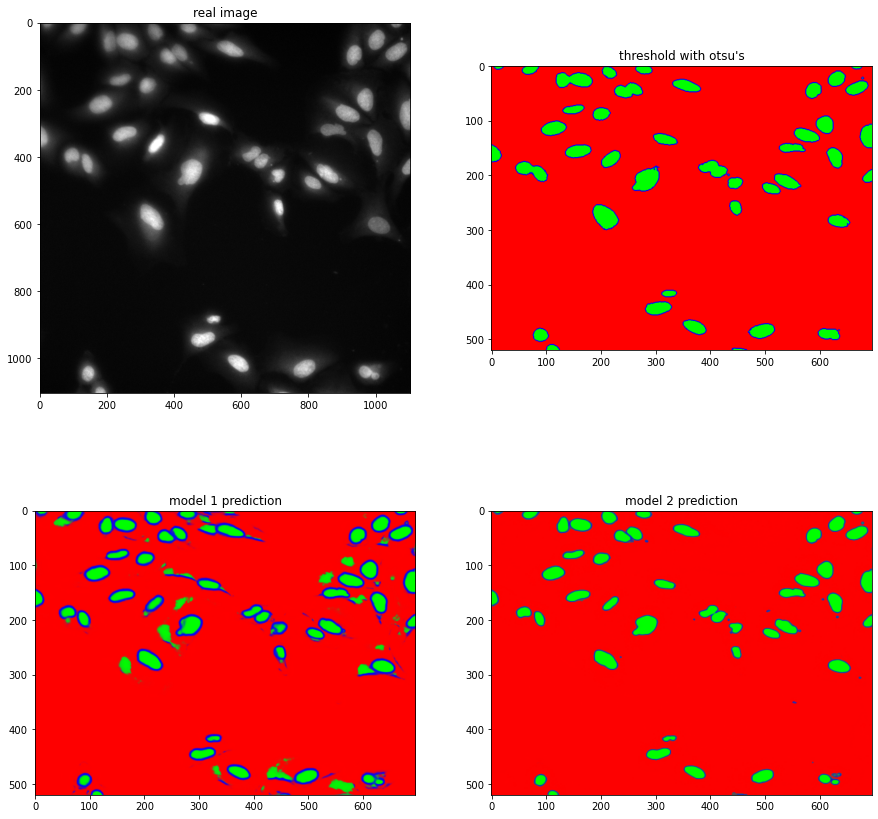

Image nbr: 1


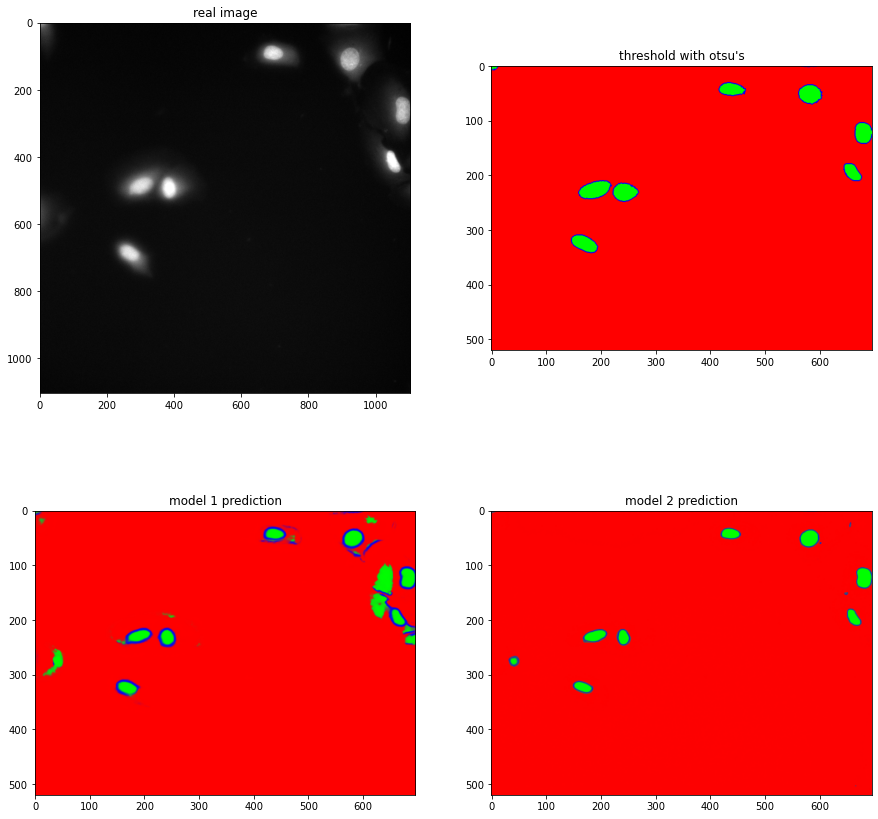

Image nbr: 2


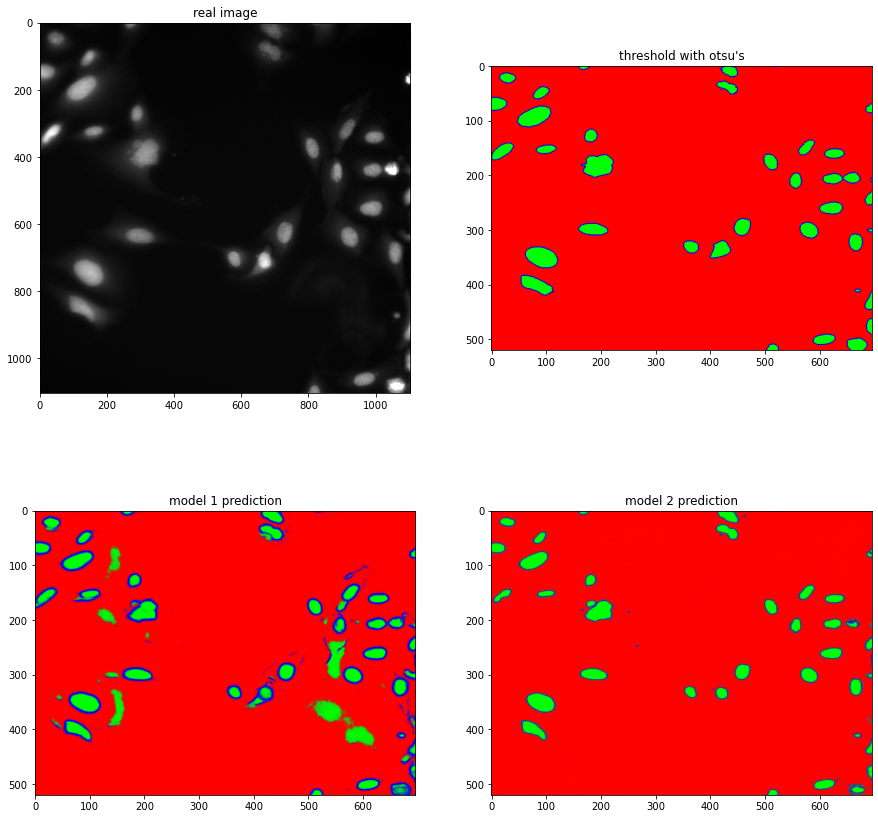

Image nbr: 3


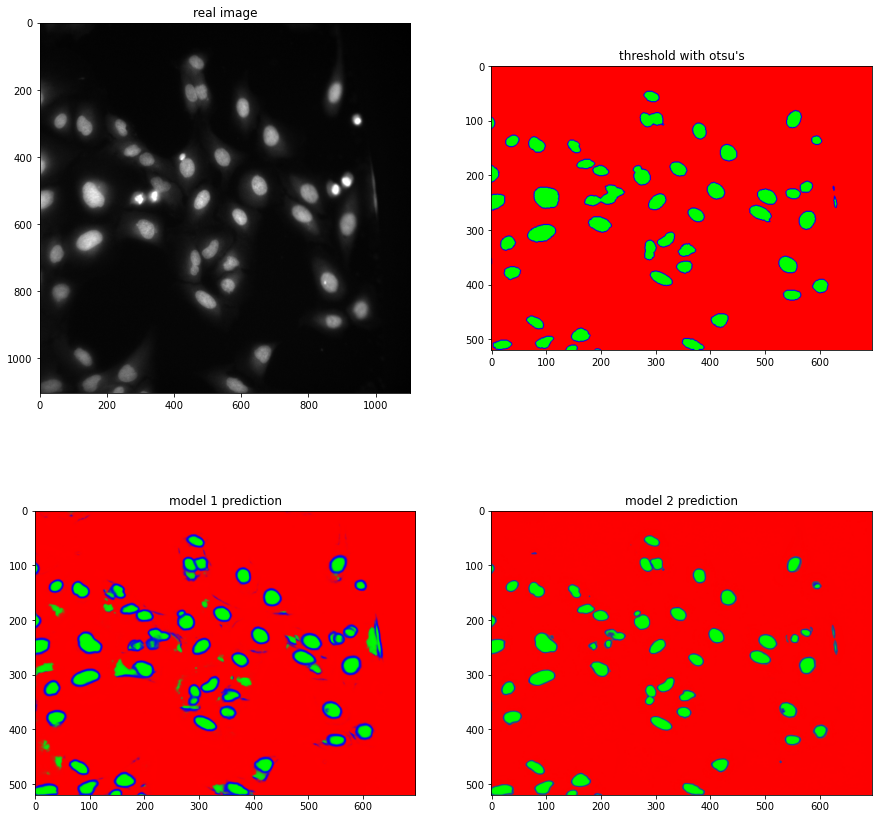

Image nbr: 4


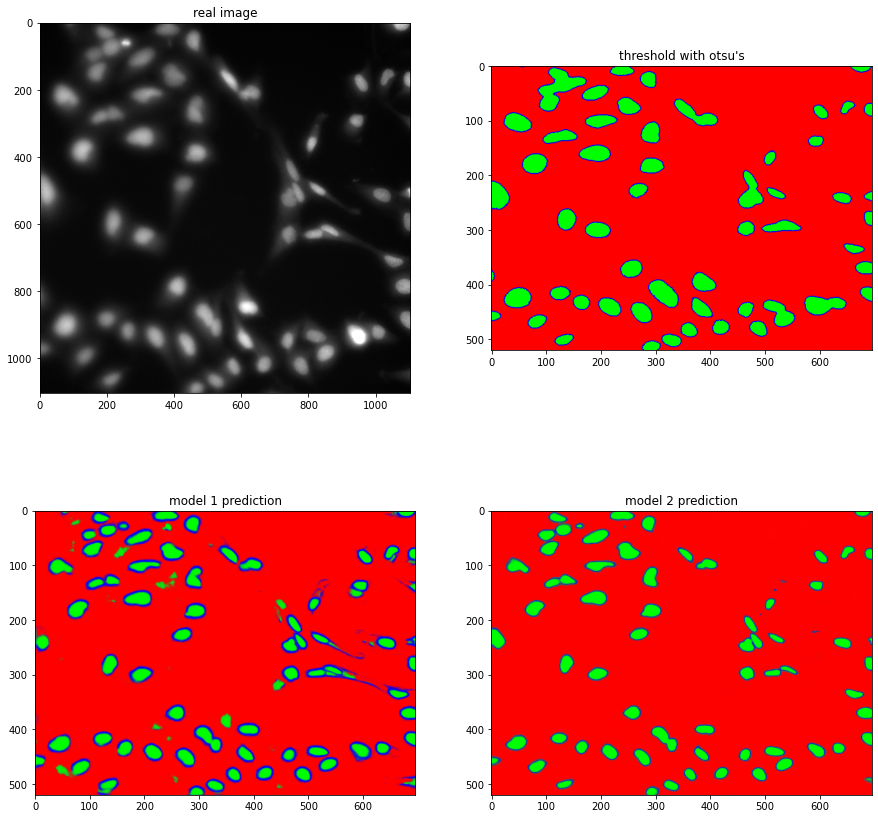

Image nbr: 5


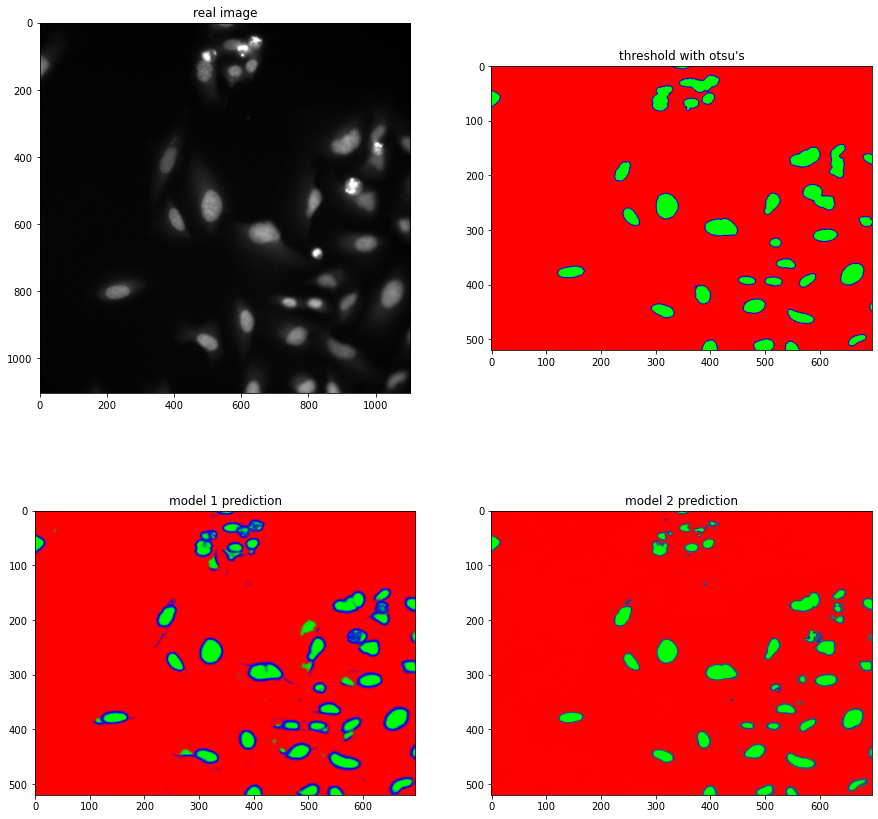

Image nbr: 6


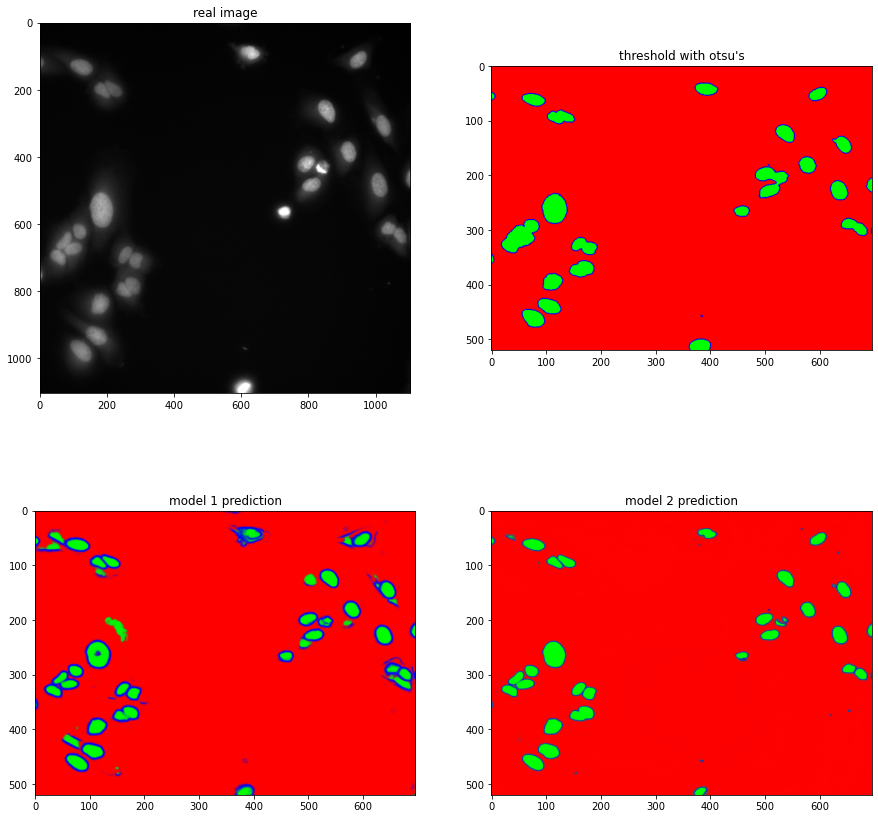

Image nbr: 7


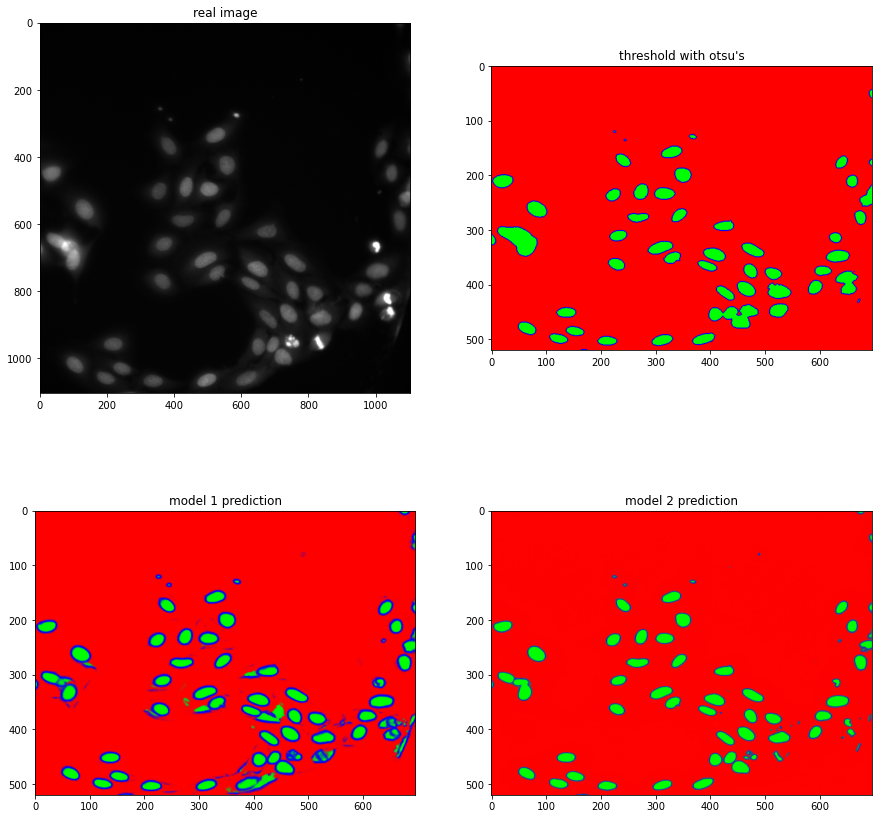

Image nbr: 8


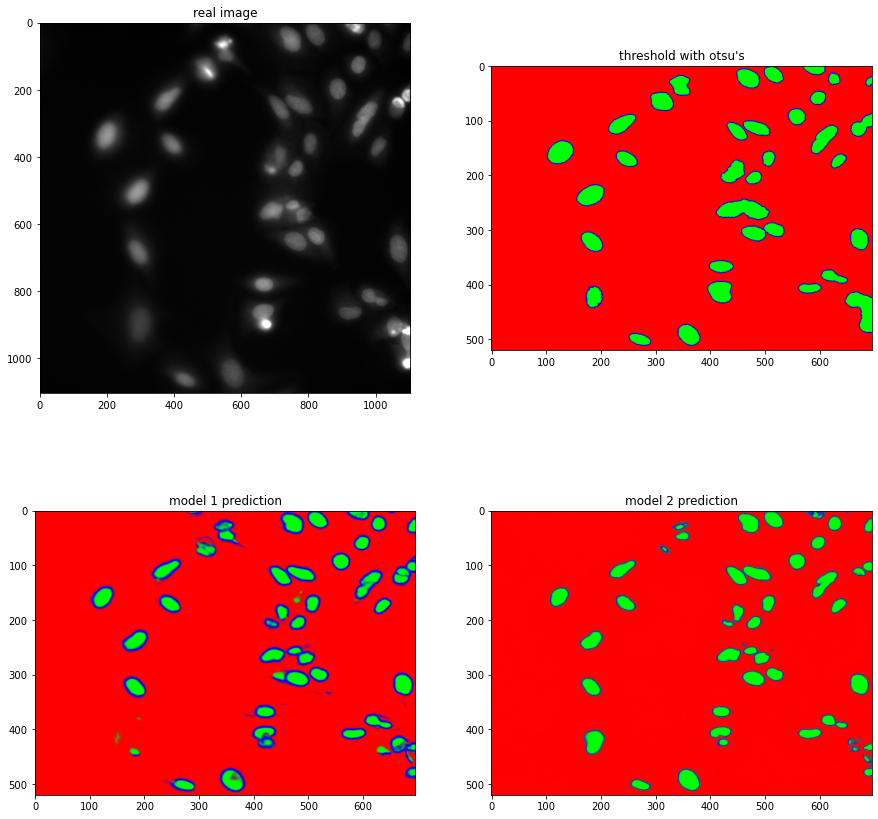

Image nbr: 9


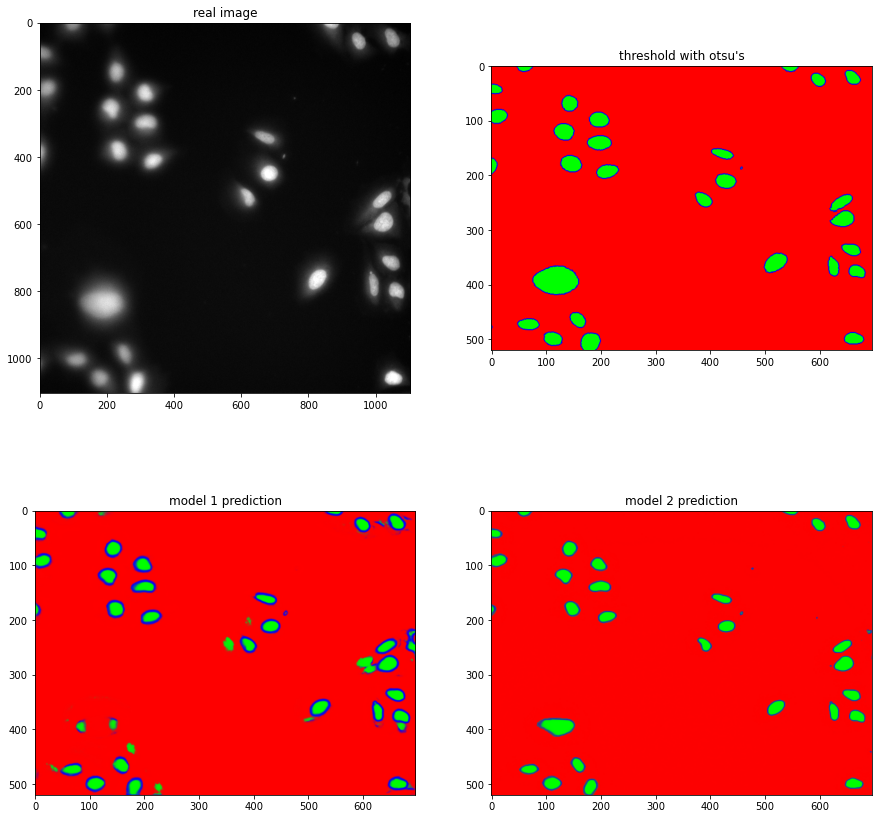

Image nbr: 10


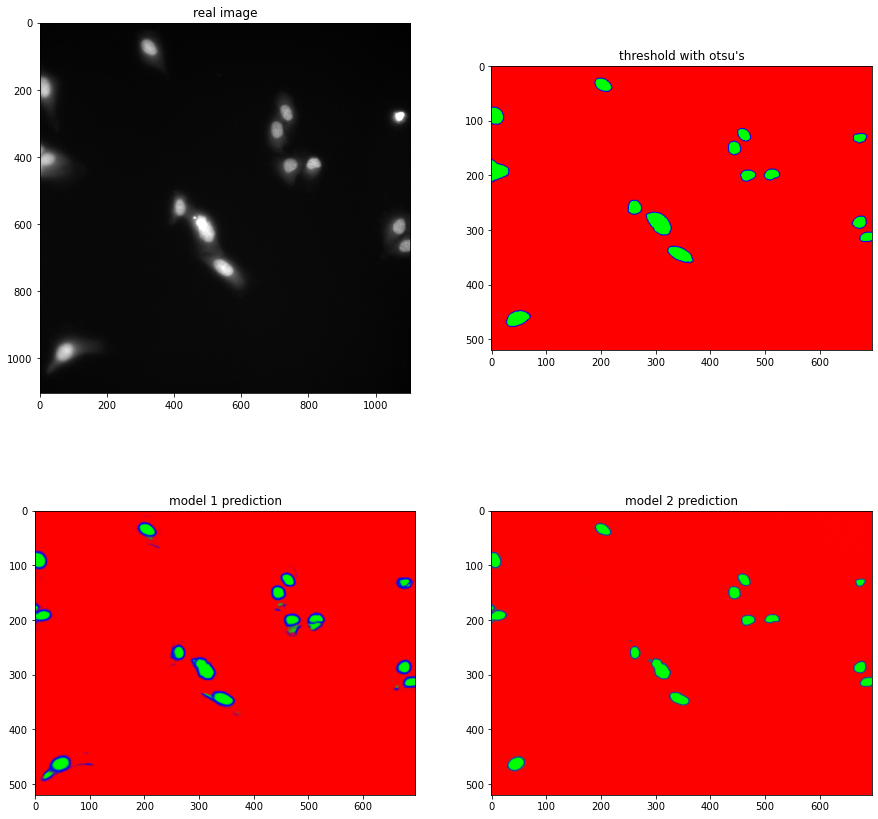

Image nbr: 11


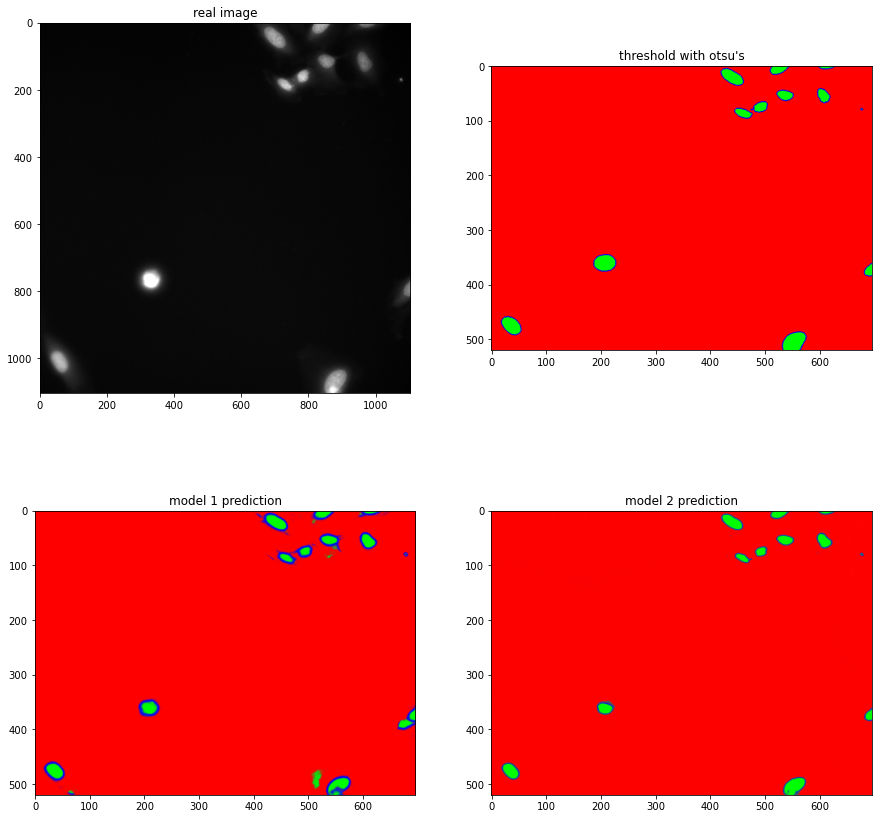

Image nbr: 12


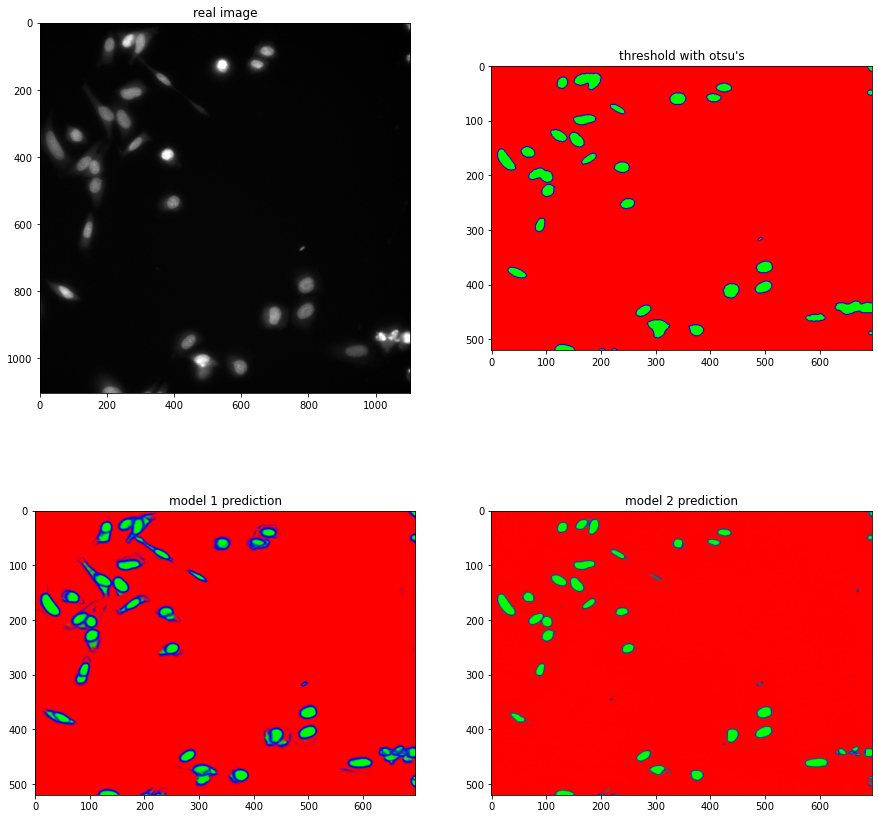

Image nbr: 13


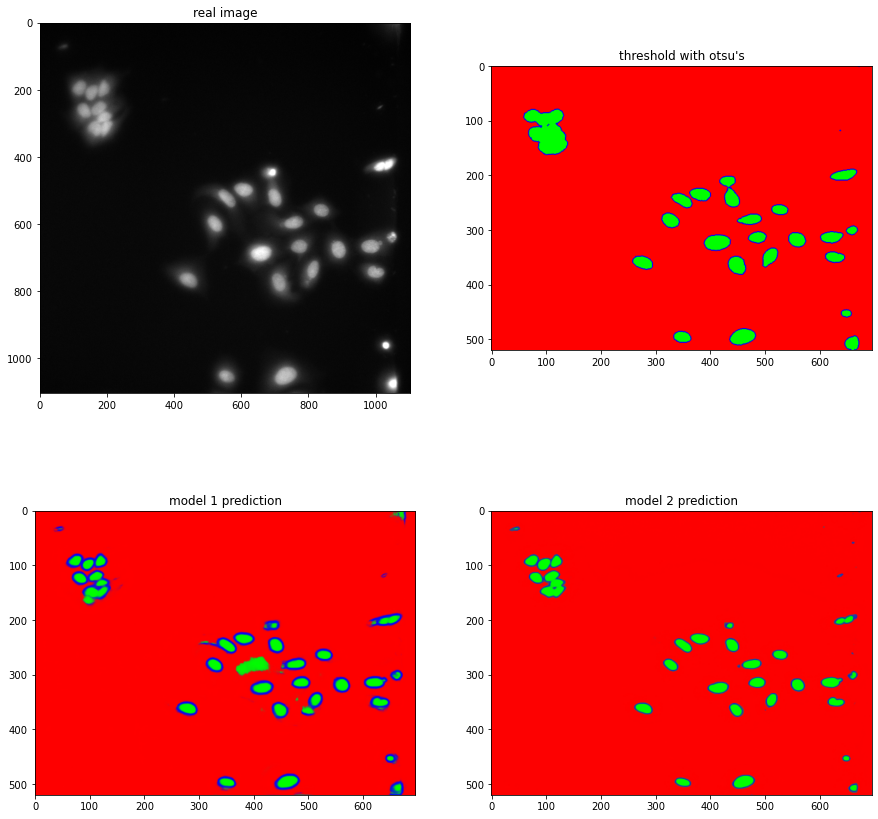

In [31]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/norm_images'))
filename = [f for f in filename if len(f)==35]
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename]
#image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

normal_images = skimage.io.imread_collection(image_names)
normal_images = normal_images.concatenate()

threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/otsus', f) for f in filename]
#threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])

imagebuffer = skimage.io.imread_collection(threshold_image_names)
images = imagebuffer.concatenate()

pred_images = sorted(os.listdir('/home/jupyter/experiments/aits2/out/prob'))
pred_names = [os.path.join('/home/jupyter/experiments/aits2/out/prob', f) for f in filename]
#pred_names.remove('/home/jupyter/experiments/aits2/out/prob/.ipynb_checkpoints')

pred_images = skimage.io.imread_collection(pred_names)
pred_images = pred_images.concatenate()


pred_images2 = sorted(os.listdir('/home/jupyter/experiments/MA_3/out/prob'))
pred_names2 = [os.path.join('/home/jupyter/experiments/MA_3/out/prob', f) for f in filename]
#pred_names2.remove('/home/jupyter/experiments/aits2/out/prob/.ipynb_checkpoints')

pred_images2 = skimage.io.imread_collection(pred_names2)
pred_images2 = pred_images2.concatenate()

for n,i in enumerate(images):
    print("Image nbr: " + str(n))
    plt.figure(figsize=(15,15))
    plt.subplot(221)
    plt.title("real image")
    plt.imshow(normal_images[n], cmap='gray')
    plt.subplot(222)
    plt.title("threshold with otsu's")
    plt.imshow(i)
    plt.subplot(223)
    plt.title("model 1 prediction")
    plt.imshow(pred_images[n])
    plt.subplot(224)
    plt.title("model 2 prediction")
    plt.imshow(pred_images2[n])
    plt.show()
    #plt.savefig("comp.png")

#### Numerical evalation of model 1 and 2 

##### Metric info

> f1 is harmonic mean of precision and recall:
>
> $$f_1 = 2* \frac{precision*recall}{precision+recall}$$
>
> the f1 score becomes high when precision and recall are high at the same time. 
>
> having very high precision but low recall will yield low f1 score. 
>
> Jaccard index is the intersection over union (similar elements / all elements): 
>
> $$ Jaccard = \frac{A \cap B}{A \cup B} $$

##### Model 1 (only trained on Broad institute images)

In [44]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
#partition = "validation"

experiment_name = 'aits2' #

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

#data_partitions = utils.dirtools.read_data_partitions(config_vars)

#config_vars

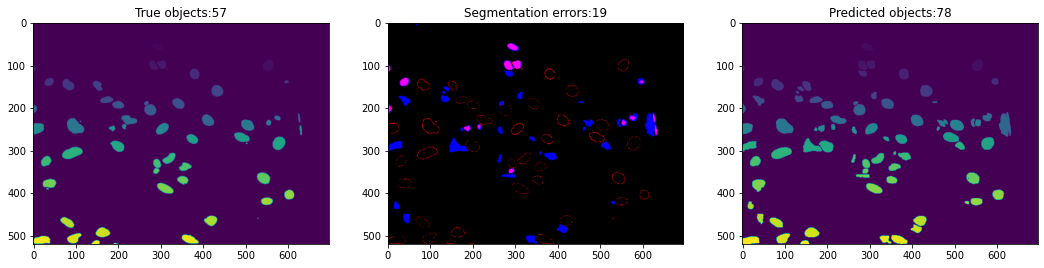

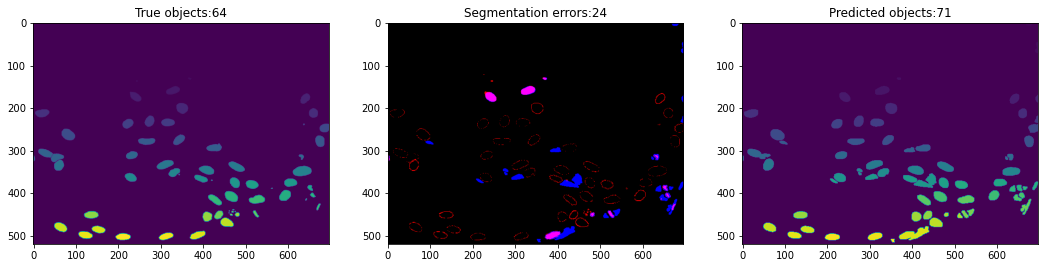

In [45]:
all_images = sorted(['MFGTMPcx7_170803210001_B19f26d0.png', 'MFGTMPcx7_170803210001_J12f29d0.png'])

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join('/home/jupyter/aitslab_images/raw_annotations/', image_name)
    ground_truth = skimage.io.imread(img_filename)
    ground_truth = skimage.morphology.label(ground_truth)
    ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)
    
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    #prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    prediction = skimage.io.imread(pred_filename)
        
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)
    if image_name == all_images[1]:
        show(ground_truth, prediction, image_name=image_name)
        

In [46]:
# Collect evaluation data
average_performance = results.groupby("Threshold").mean().reset_index()
R = results.groupby("Image").mean().reset_index()
#g = sb.jointplot(data=R[R["F1"] > 0], x="Jaccard", y="F1")

Threshold        F1   Jaccard
0       0.50  0.571429  0.367652
1       0.55  0.503759  0.367652
2       0.60  0.360902  0.367652
3       0.65  0.195489  0.367652
4       0.70  0.097744  0.367652
5       0.75  0.015038  0.367652
6       0.80  0.000000  0.367652
7       0.85  0.000000  0.367652
8       0.90  0.000000  0.367652
9       0.95  0.000000  0.367652

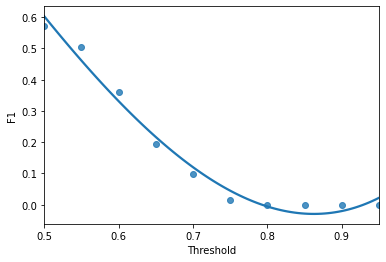

In [47]:
# Plot accuracy results
sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [51]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.17443609022425238
Jaccard index: 0.3676524976632347


In [48]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      34.0
Small nuclei     65.0
Normal nuclei     7.0
Large nuclei      NaN
Name: False_Negative, dtype: float64

In [49]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 134


##### Model 2 (trained with manually annotated images)

In [56]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
#partition = "validation"

experiment_name = 'MA_3' #

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

#data_partitions = utils.dirtools.read_data_partitions(config_vars)

#config_vars

In [33]:
# Function to Display prediction along with segmentation to visualize errors
def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    #ax[3].imshow(IOU)
    #ax[3].set_title(image_name)

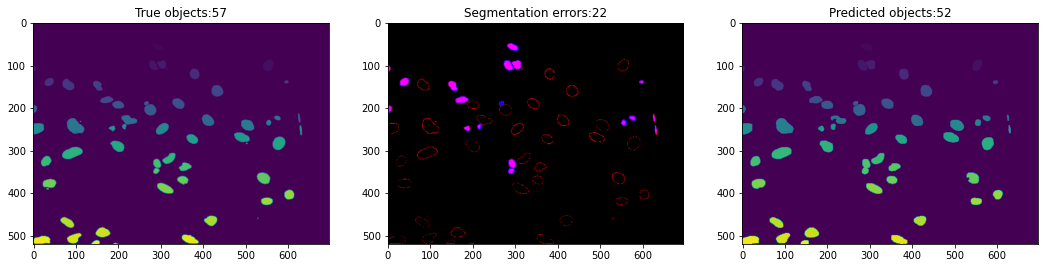

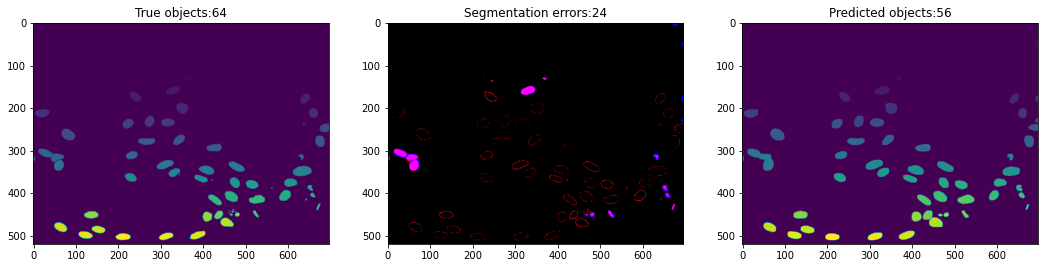

In [57]:
all_images = sorted(['MFGTMPcx7_170803210001_B19f26d0.png', 'MFGTMPcx7_170803210001_J12f29d0.png'])

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join('/home/jupyter/aitslab_images/raw_annotations/', image_name)
    ground_truth = skimage.io.imread(img_filename)
    ground_truth = skimage.morphology.label(ground_truth)
    ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)
    
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    #prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    prediction = skimage.io.imread(pred_filename)
        
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)
    if image_name == all_images[1]:
        show(ground_truth, prediction, image_name=image_name)
        

In [58]:
# Collect evaluation data
average_performance = results.groupby("Threshold").mean().reset_index()
R = results.groupby("Image").mean().reset_index()
#g = sb.jointplot(data=R[R["F1"] > 0], x="Jaccard", y="F1")

Threshold        F1   Jaccard
0       0.50  0.648265  0.503759
1       0.55  0.552431  0.503759
2       0.60  0.369238  0.503759
3       0.65  0.245367  0.503759
4       0.70  0.108665  0.503759
5       0.75  0.026295  0.503759
6       0.80  0.008475  0.503759
7       0.85  0.000000  0.503759
8       0.90  0.000000  0.503759
9       0.95  0.000000  0.503759

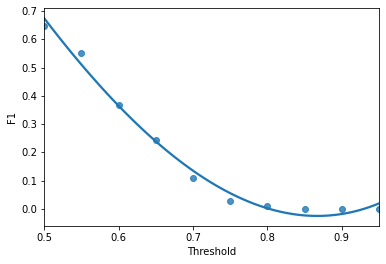

In [59]:
# Plot accuracy results
sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [60]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.1958735941690027
Jaccard index: 0.5037591479324374


In [61]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      34.0
Small nuclei     66.0
Normal nuclei     7.0
Large nuclei      NaN
Name: False_Negative, dtype: float64

> 0-250 [pixels^2] = tiny
>
> 250-625 = small
>
> 625-900 = normal
>
> 900-10000 = large
>
> Entire image is 361920 pixels^2 

In [62]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 94
